In [2]:
import os
from tqdm import tqdm

# images and dataset management
import numpy as np
import pandas as pd

# plot figures
import matplotlib.pyplot as plt

# split dataset
from sklearn.model_selection import train_test_split

# data management and CNN
import torch
from torch.utils.data import DataLoader
from torchvision import transforms


In [4]:
    # =========================================================================
    #       DIRECTORIES
    # =========================================================================
    modelDir = os.path.join(os.path.dirname(os.getcwd()), 'saved_models')
    dataDir  = os.path.join(os.getcwd(), 'dataset')
    trainDir = os.path.join(dataDir, 'train')

    # =========================================================================
    #       LOADING DATASET
    # =========================================================================
    train = pd.read_csv(os.path.join(dataDir, 'train.csv'))

In [5]:
train.head()

,id,label
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
train['label'].value_counts()

1    13136
0     4364
Name: label, dtype: int64

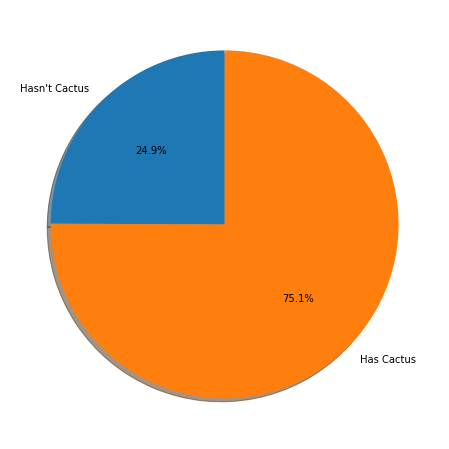

In [10]:
label = 'Hasn\'t Cactus', 'Has Cactus'
plt.figure(figsize = (8,8))
plt.pie(train.groupby('label').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

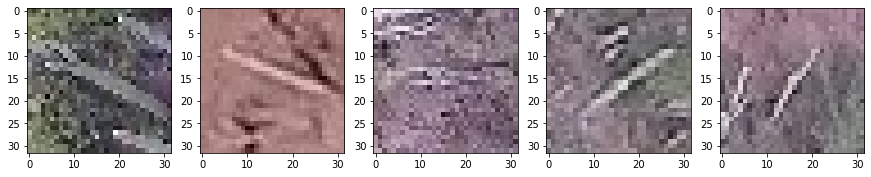

In [8]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(train[train['label'] == 1]['id'][-5:]):
    path = os.path.join(trainDir, idx)
    ax[i].imshow(img.imread(path))

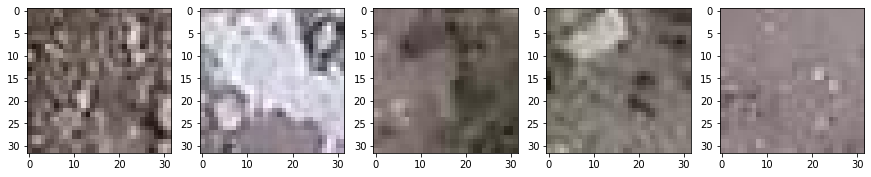

In [9]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(train[train['label'] == 0]['id'][:5]):
    path = os.path.join(trainDir, idx)
    ax[i].imshow(img.imread(path))

In [12]:
    # =========================================================================
    #       PREPARING IMAGES TRANSFORMATIONS
    # =========================================================================
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    trainTransform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean, std)])
    validTransform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean, std)])

In [3]:
    # =========================================================================
    #       SPLITING DATASET : training and validation
    # =========================================================================
    train, validation = train_test_split(train, stratify=train.label, test_size=0.1)  # 10% for validation

    from CactusDataset import CactusDataset
    trainData = CactusDataset(train, trainDir, trainTransform)
    validData = CactusDataset(validation, trainDir, validTransform)

In [4]:
    # =========================================================================
    #       HYPER PARAMETERS / CUDA / DATALOADER
    # =========================================================================
    from config import config

    # hyper parameters
    epochs  = config['epochs']
    classes = config['classes']
    batchSize = config['batchSize']
    workers = config['workers']

    # load each dataset
    trainLoader = DataLoader(dataset=trainData, batch_size=batchSize, shuffle=True, num_workers=workers)
    validLoader = DataLoader(dataset=validData, batch_size=batchSize, shuffle=False, num_workers=workers)

In [5]:
    # =========================================================================
    #       INIT TRAINING
    # =========================================================================
    from CNN_v2 import model, optimizer, criterion
    from utils import training
    
    train_losses, val_losses = [], []

    for epoch in tqdm(range(epochs)):
        training(epoch, model, optimizer, criterion, 
                 trainLoader, validLoader, train_losses, val_losses)


100%|██████████| 35/35 [19:11<00:00, 32.89s/it]Epoch: 34 Training Loss: 0.046574 Validation Loss: 0.026574



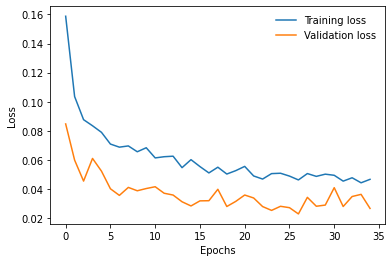

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [8]:
    # =========================================================================
    #       EVALUATING AND SAVING THE MODEL
    # =========================================================================
    from utils import evaluate
    SAVE_MODE = False

    accuracy = evaluate(model, validLoader)
    print('ACCURACY : {}'.format(accuracy))

    if SAVE_MODE:
        torch.save(model.state_dict(), os.path.join(modelDir, 'cactusModel.ckpt'))


ACCURACY : 99.2


In [11]:
    # =========================================================================
    #       TESTING MODEL LOADING
    # =========================================================================
    from config import device
    from CNN_v2 import CNN_v2
    from utils import evaluate

    # Loading model
    modelPath = os.path.join(modelDir, 'cactusModel.ckpt')
    model = CNN_v2()
    model.load_state_dict(torch.load(modelPath))
    model.to(device)

    # testing
    accuracy = evaluate(model, validLoader)
    print('ACCURACY : {}'.format(accuracy))

NameError: name 'validLoader' is not defined